Edwin Bosch

Original Credit: Carly Raskin and Edwin Bosch in collaboration

Citation request: Raskin, Carly, and Edwin Bosch. “Machine Learning Project 3.” Google Colab, Google, 21 Aug. 2022, colab.research.google.com/drive/1YCCf4URJTFhsEHbFTnlWrdDCp6ylWhY5. 

# **Experiment Objective**
---

Our object would be: to identify the type of pistacio based on the image. 

Citation Request:

1: SINGH D, TASPINAR YS, KURSUN R, CINAR I, KOKLU M, OZKAN IA, LEE H-N., (2022). Classification and Analysis of Pistachio Species with Pre-Trained Deep Learning Models, Electronics,11 (7), 981. https://doi.org/10.3390/electronics11070981. (Open Access)

DOI: https://doi.org/10.3390/electronics11070981

2: OZKAN IA., KOKLU M. and SARACOGLU R. (2021). Classification of Pistachio Species Using Improved K-NN Classifier. Progress in Nutrition, Vol. 23, N. 2. https://doi.org/10.23751/pn.v23i2.9686. (Open Access)

DOI: https://doi.org/10.23751/pn.v23i2.9686

https://www.muratkoklu.com/datasets/

New data set. Airplanes and cars. Advice from prof:

my usual approach is to take some small subset (say 10 images) and work on the loading and preprocessing one step at a time. start with a function that loads and decodes a single image, then create the code that loads multiple images and associates the labels, then experiment with data augmentation and any other preprocessing you need to do. the end goal is to get a set of functions that can reliably load or reload your dataset, associate your labels (in training), crop/resize, apply the augmentation if necessary, then return a tensor with the desired dimensions for your model (batch_size, height, width, channels)

# **Data Collection and Preprocessing**
---

Change to work on your drive

In [17]:
from google.colab import drive
google_drive_root='Project03'
google_drive_mount_location = '/content/drive'
google_file_prefix=google_drive_mount_location + '/My Drive/Machine Learning/' + google_drive_root + '/'
drive.mount(google_drive_mount_location)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions

In [19]:
# declare directory prefixes for train and test datasets
data_dir_train = google_file_prefix+"images/_train"
data_dir_validate = google_file_prefix+"images/_validate"
data_dir_test = google_file_prefix+"images/_test"

#this is defined here along with other constants
num_epochs = 5
num_steps = 12

Here we create load our image datasets

In [20]:
# load the data
train_ds = tf.keras.utils.image_dataset_from_directory(data_dir_train,
                                                       image_size=(256, 256),
                                                       labels="inferred",
                                                       label_mode="categorical")
test_ds = tf.keras.utils.image_dataset_from_directory(data_dir_validate,
                                                       image_size=(256, 256),
                                                       labels="inferred",
                                                       label_mode="categorical")
sp_test_ds = tf.keras.utils.image_dataset_from_directory(data_dir_test,
                                                       image_size=(256, 256),
                                                       labels="inferred",
                                                       label_mode="categorical")
class_names = train_ds.class_names
class_names

Found 2160 files belonging to 3 classes.
Found 323 files belonging to 3 classes.
Found 15 files belonging to 3 classes.


['airplane', 'car', 'motorbike']

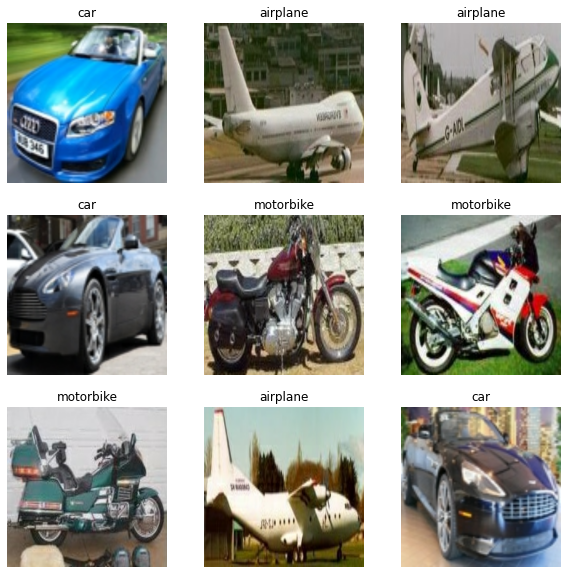

In [21]:
# this is purely a graph
def fixer(tensor):
  if tensor[0] == 1:
    return 0
  elif tensor[1] == 1:
    return 1
  else:
    return 2

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[fixer(labels[i])])
    plt.axis("off")


# **TensorFlow Model Creation**
---

### Explanation

We chose the two imput convolutional laayers because they provide a basic starting place for image analysis. We added two large hidden layers for better accuracy and found good results.

After tinkering some more it seems a large third hidden layer at the beggging of hidden layers is not that helpful or computationaly feasible. This is true of larger opening layers as well as deeper (6+) hidden layers. The one layer model is the best and correctly identified the test images.

However it is still making a lot of mistakes and I am wondering why or how to make it better. Increasing the size of the hidden layer also does not help. Maybe shrinking it?

In [22]:

model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(64, kernel_size=3, activation="relu", 
                                 input_shape=(256, 256, 3)))

model.add(tf.keras.layers.Conv2D(32, kernel_size=3, activation="relu"))

model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_2'))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(
    units=512, name='fc_1', 
    activation='relu'))

model.add(tf.keras.layers.Dropout(
    rate=0.5))

model.add(tf.keras.layers.Dense(3, activation="softmax", name='decoder_dense'))


In [23]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 254, 254, 64)      1792      
                                                                 
 conv2d_3 (Conv2D)           (None, 252, 252, 32)      18464     
                                                                 
 pool_2 (MaxPooling2D)       (None, 126, 126, 32)      0         
                                                                 
 flatten_1 (Flatten)         (None, 508032)            0         
                                                                 
 fc_1 (Dense)                (None, 512)               260112896 
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 decoder_dense (Dense)       (None, 3)                

# **Model Training**
---

4 deep:0.7422

6 deep:worse

1 deep:0.7943, 0.7585

2 deep:0.6667, 0.6285

half-width:0.8490, 0.8916

quater-width:0.7760, 0.8545

half-width again (512):0.8333, 0.8545

From some trail and error it seems that one small hidden layer inside the convolutional context works best for a reasonable amount of computing power. I suspect a server farm could produce better results with an enormous network, but here all the additional neurons seem to do is add noise.

In [24]:
result = model.fit(train_ds, epochs = num_epochs, 
                   steps_per_epoch=num_steps,
                   validation_data=test_ds)

Epoch 1/5
12/12 [==============================] - 93s 8s/step - loss: 2995.6018 - accuracy: 0.4297 - val_loss: 7.5491 - val_accuracy: 0.7430
Epoch 2/5
12/12 [==============================] - 97s 8s/step - loss: 2.2035 - accuracy: 0.8125 - val_loss: 0.9625 - val_accuracy: 0.8204
Epoch 3/5
12/12 [==============================] - 105s 9s/step - loss: 0.8723 - accuracy: 0.8203 - val_loss: 0.5376 - val_accuracy: 0.8483
Epoch 4/5
12/12 [==============================] - 100s 8s/step - loss: 1.0799 - accuracy: 0.8021 - val_loss: 0.7026 - val_accuracy: 0.8545
Epoch 5/5
12/12 [==============================] - 95s 8s/step - loss: 0.6377 - accuracy: 0.8333 - val_loss: 0.5777 - val_accuracy: 0.8545


# **Model Evaluation**
---

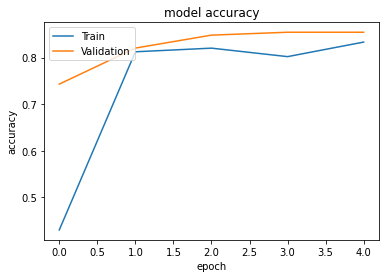

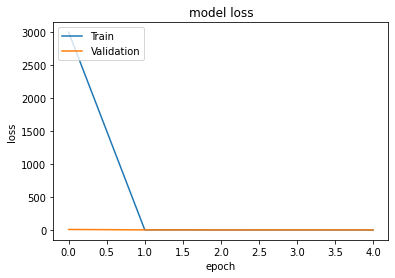

In [25]:
history = result
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [26]:
def item_prediction(new_image):
  test_image = tf.keras.preprocessing.image.load_img(new_image, target_size = (256,256))
  plt.axis("off")
  plt.imshow(test_image)
  plt.show()

  test_image = tf.keras.preprocessing.image.img_to_array(test_image) / 255
  test_image = np.expand_dims(test_image, axis=0)
 
  predicted_array = model.predict(test_image)
  print(predicted_array)
  print(np.argmax(predicted_array))
  predicted_value = class_names[np.argmax(predicted_array)]
  predicted_accuracy = round(np.max(predicted_array) * 100, 2)

  print("Your picture is ", predicted_value, " with ", predicted_accuracy, " % accuracy")


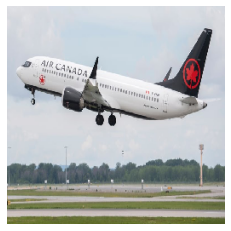

[[0.38893694 0.31849593 0.29256716]]
0
Your picture is  airplane  with  38.89  % accuracy


In [27]:
item_prediction(google_file_prefix+"airplane_.jpg")

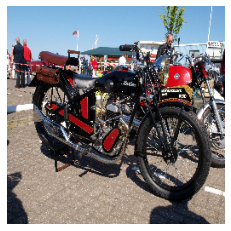

[[0.31694883 0.3839753  0.29907584]]
1
Your picture is  car  with  38.4  % accuracy


In [28]:
item_prediction(google_file_prefix+"motorbike_.jpg")

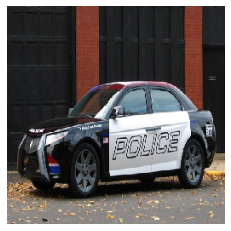

[[0.29531375 0.45372105 0.25096518]]
1
Your picture is  car  with  45.37  % accuracy


In [29]:
item_prediction(google_file_prefix+"car_.jpg")

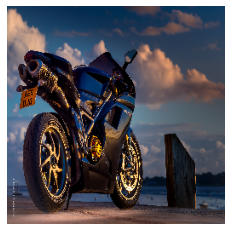

[[0.31973025 0.3767099  0.30355978]]
1
Your picture is  car  with  37.67  % accuracy


In [30]:
item_prediction(google_file_prefix+"hard_motorbike.jpg")

In [31]:
evaluation = model.evaluate(test_ds, return_dict=True, verbose=1)
print("Accuracy on validation data: " + str(int(100*evaluation["accuracy"])) + "%")

11/11 [==============================] - 14s 1s/step - loss: 0.5777 - accuracy: 0.8545
Accuracy on validation data: 85%


In [32]:
evaluation = model.evaluate(sp_test_ds, return_dict=True)
print("Accuracy on test data: " + str(int(100*evaluation["accuracy"])) + "%")


1/1 [==============================] - 1s 1s/step - loss: 4.4194 - accuracy: 0.7333
Accuracy on validation data: 73%


# Conclusion

Our model did indeed perform well once we were able to get it working. However identifying cars from motorbikes is not an easy conclusion for such a small network. 